In [64]:
import pandas as pd
import numpy as np
import pickle
import os
import copy
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                        roc_curve, auc, roc_auc_score, log_loss)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from feature_sets_center_less import GenerateFeatures
from essentials import complete_preprocessing_pipeline, normalization

In [65]:
with open('../data/df_dict_imu.pkl', 'rb') as f:
    imu_dict = pickle.load(f)
with open('../data/df_dict_urineestimate_method1.pkl', 'rb') as f:
    urine_estimates_dict = pickle.load(f)
with open('../data/df_minze_dict.pkl', 'rb') as f:
    ground_truth_dict = pickle.load(f)

In [66]:
del imu_dict['subj_9_void4']
del imu_dict['subj_11_void2']

In [67]:
data_dict = copy.deepcopy(imu_dict)
labelled_imu_dict = complete_preprocessing_pipeline(data_dict, ground_truth_dict, 
                                target_fs=60,normalize_data=False, use_three_classes=False)

Step 1: Resampling data to 60 Hz...


  0%|          | 0/41 [00:00<?, ?it/s]

Step 2: Processing each instance: 100%|██████████| 41/41 [00:00<00:00, 100.98it/s]


In [68]:
# Add experiment_id to each dataframe and append to imu_dict
imu_list = []
for i, key in enumerate(labelled_imu_dict.keys()):
    df  = labelled_imu_dict[key]
    df['experiment_id'] = i + 1

    imu_list.append(df)

In [69]:
# Concatenate all the dataframes in imu_dict into a single dataframe
main_df = pd.concat(imu_list, ignore_index=True)

In [70]:
main_df

,time,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,label,experiment_id
0,0.000000,0.066242,-13.923373,-17.075456,-38.322404,8.725663,83.141039,non-void,1
1,0.016672,0.042377,-13.943841,-17.017971,-26.512188,2.859905,81.112387,non-void,1
2,0.033344,0.008036,-13.984501,-16.977426,-13.290214,-2.208047,90.963856,non-void,1
3,0.050016,-0.011408,-14.014916,-16.958092,-5.035968,-4.649128,128.658540,non-void,1
4,0.066688,0.012667,-13.938258,-16.923885,3.089309,-1.511407,184.109181,non-void,1
...,...,...,...,...,...,...,...,...,...
145221,41.109668,-0.414715,-9.773258,-5.399930,-5.878189,-39.491056,5.752304,non-void,41
145222,41.126339,-0.446581,-9.757047,-5.420230,-14.090114,-42.481000,-8.307202,non-void,41
145223,41.143010,-0.432605,-9.771430,-5.389436,-23.564834,-46.225333,-23.997358,non-void,41
145224,41.159680,-0.406158,-9.756612,-5.327400,-19.459784,-51.782481,-38.238428,non-void,41


In [71]:
y = main_df['label']
groups = main_df['experiment_id']

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(main_df, y, groups))

data_train, data_test = main_df.iloc[train_idx], main_df.iloc[test_idx]
groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

In [72]:
# Apply global normalization
data_train_norm, data_test_norm = normalization(data_train, data_test)
print(f"✓ Applied global normalization")
print(f"Train experiments: {sorted(groups_train.unique())}")
print(f"Test experiments: {sorted(groups_test.unique())}")

✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(27), np.int64(28), np.int64(29), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39)]
Test experiments: [np.int64(5), np.int64(9), np.int64(14), np.int64(20), np.int64(25), np.int64(26), np.int64(30), np.int64(40), np.int64(41)]


In [99]:
def dataframe_to_dict_by_experiment(df: pd.DataFrame) -> dict:
    """Convert DataFrame to dictionary with experiment_id as key"""
    experiment_dict = {}
    for exp_id in df['experiment_id'].unique():
        exp_data = df[df['experiment_id'] == exp_id].copy()
        exp_data = exp_data.drop(columns=['experiment_id'])
        # IMPORTANT: Reset index to avoid KeyError in feature extraction
        exp_data = exp_data.reset_index(drop=True)
        experiment_dict[f'exp_{exp_id}'] = exp_data
    return experiment_dict

def extract_features_from_dict(data_dict: dict, window_size: float, overlap: float) -> pd.DataFrame:
    """Extract features from dictionary of DataFrames"""
    all_features = []
    
    for exp_key, df in data_dict.items():
        actual_exp_id = int(exp_key.split('_')[1])
        
        analyzer = GenerateFeatures(fs=60, window_duration=window_size, overlap=overlap)
        features, _ = analyzer.analyze_multi_axis_imu(df)
        
        table = analyzer.create_summary_table()
        table['experiment_id'] = actual_exp_id
        all_features.append(table)
    
    return pd.concat(all_features, ignore_index=True)

In [100]:
# Convert normalized DataFrames to dictionaries for feature extraction
train_dict = dataframe_to_dict_by_experiment(data_train_norm)
test_dict = dataframe_to_dict_by_experiment(data_test_norm)

In [101]:
# Extract features
print(f"Extracting features...")
train_features = extract_features_from_dict(train_dict, 5, 0.5)
test_features = extract_features_from_dict(test_dict, 5, 0.5)

Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 21.85it/s]


In [109]:
test_features_ = copy.deepcopy(test_features)

In [110]:
train_features.drop(columns=['center_time', 'start_time', 'end_time'], inplace=True)
test_features.drop(columns=['center_time', 'start_time', 'end_time'], inplace=True)

In [78]:
groups_train.unique()

array([ 1,  2,  3,  4,  6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21,
       22, 23, 24, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [79]:
X_train, X_test = train_features.drop(columns=['label', 'experiment_id']), test_features.drop(columns=['label', 'experiment_id'])
y_train, y_test = train_features['label'], test_features['label']
groups_train, groups_test = train_features['experiment_id'], test_features['experiment_id']

In [80]:
X_train

,acc_x_permutation_entropy,acc_x_spectral_entropy,acc_x_mean,acc_x_std,acc_x_range,acc_x_rms,acc_x_min,acc_x_max,acc_x_time_energy,acc_x_spectral_centroid,...,gyr_z_max,gyr_z_time_energy,gyr_z_spectral_centroid,gyr_z_spectral_spread,gyr_z_spectral_flatness,gyr_z_peak_frequency_ratio,gyr_z_hjorth_frequency,gyr_z_spectral_skewness,gyr_z_spectral_kurtosis,gyr_z_snr
0,0.866765,0.727586,-0.166089,0.080136,0.621081,0.184411,-0.396381,0.224700,10.202225,4.158656,...,0.771653,7.912131,2.195983,1.840313,0.008626,0.171723,7.640504,3.527473,18.450942,-6.833457
1,0.890166,0.731273,-0.191579,0.075930,0.621556,0.206077,-0.533911,0.087645,12.740335,4.048998,...,0.578737,4.362488,2.402178,2.963912,0.025916,0.152693,8.811304,2.185009,7.989944,-7.442230
2,0.889209,0.739116,-0.194347,0.080998,0.621556,0.210551,-0.533911,0.087645,13.299493,4.704037,...,0.578737,6.698603,3.178037,3.311781,0.048599,0.212650,8.557379,1.818784,7.211402,-5.685017
3,0.873850,0.796096,-0.189579,0.049703,0.328841,0.195987,-0.329061,-0.000220,11.523217,5.018500,...,0.319033,4.158992,1.927444,2.229758,0.014291,0.200791,8.648246,3.405201,15.967770,-5.999173
4,0.862154,0.779172,-0.205175,0.054988,0.404462,0.212416,-0.370200,0.034262,13.536115,4.689019,...,0.319033,2.695201,4.025375,3.313482,0.040388,0.203372,8.933817,1.404789,4.643492,-5.929645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,0.889064,0.656619,-0.544657,0.242892,1.196110,0.596362,-1.312218,-0.116107,106.694332,6.480274,...,0.306382,58.094116,1.565848,3.488281,0.031490,0.461726,11.668813,4.056817,20.884306,-0.666184
658,0.851085,0.595753,-0.864813,0.279986,1.190878,0.909007,-1.471914,-0.281036,247.887885,5.904987,...,0.829334,69.273469,0.977386,2.322035,0.010810,0.593663,11.046851,4.524813,27.310845,1.646534
659,0.862006,0.569320,-0.975926,0.195278,0.950953,0.995271,-1.471914,-0.520961,297.169510,8.800450,...,0.829334,20.467210,2.639209,4.038465,0.044648,0.209177,10.938796,2.376906,9.800739,-5.775643
660,0.848055,0.547134,-1.055384,0.257560,1.198287,1.086357,-1.719247,-0.520961,354.051568,6.371891,...,0.729561,24.019736,3.439353,4.347204,0.046573,0.384959,10.367846,1.374905,4.936284,-2.034901


In [81]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [82]:
select_feature = SelectKBest(f_classif, k=20).fit(X_train, y_train)
selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
                                    'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
81,gyr_y_hjorth_frequency,139.842482
11,acc_x_spectral_flatness,135.391241
78,gyr_y_spectral_spread,135.147833
95,gyr_z_spectral_spread,125.213107
98,gyr_z_hjorth_frequency,122.914314
...,...,...
40,acc_z_min,1.317043
87,gyr_z_mean,0.566349
23,acc_y_min,0.386621
53,gyr_x_mean,0.104010


### XGBoost

In [83]:
model = XGBClassifier(
    n_estimators=275,
    max_depth=9,
    learning_rate=0.03376467995,
    subsample=0.7687854544,
    colsample_bytree=0.7560969795,
    min_child_weight=4,
    gamma=3.943734207,
    reg_alpha=0.8737694902,
    reg_lambda=1.188019621,
)

In [84]:
X_train_selected = select_feature.transform(X_train)
X_test_selected = select_feature.transform(X_test)

In [85]:
model.fit(X_train_selected, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7560969795
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [87]:
classes = ['non-void', 'void']

In [88]:
classes = ['non-void', 'void']
# y_pred = label_encoder.inverse_transform(model.predict(X_test_selected))
y_pred = model.predict(X_test_selected)
y_pred_prob = model.predict_proba(X_test_selected)
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_prob, axis=1))
report = classification_report(y_test, y_pred, labels=[0, 1], target_names=classes)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       149
           1       0.82      0.52      0.64        94

    accuracy                           0.77       243
   macro avg       0.79      0.72      0.73       243
weighted avg       0.78      0.77      0.76       243



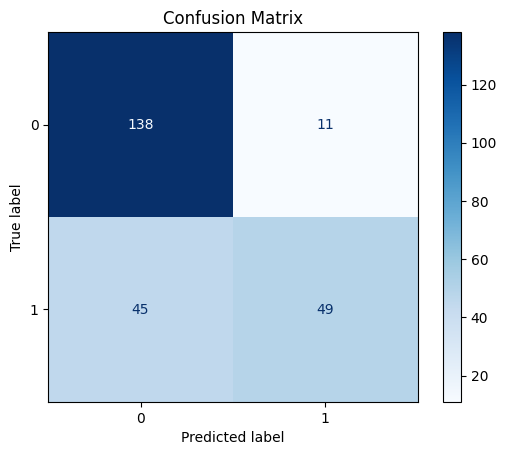

In [89]:
labels_ordered = ['void', 'non-void']
# Confusion matrix with void on top
cm = confusion_matrix(y_test, y_pred)  # [void, non-void]
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
plt.show()

### RandomForest

In [42]:
# select_feature = SelectKBest(f_classif, k=20).fit(X_train, y_train)
# selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
#                                     'Scores':select_feature.scores_})
# selected_features_df.sort_values(by='Scores', ascending=False)

In [43]:
# X_train_selected = select_feature.transform(X_train)
# X_test_selected = select_feature.transform(X_test)

In [44]:
# model = RandomForestClassifier(
#         n_estimators=311,
#         max_depth=7,
#         min_samples_split=14,
#         min_samples_leaf=9,
#         max_features='sqrt',
#         bootstrap=False,
#         class_weight='balanced',
#         random_state=42)

In [45]:
# model.fit(X_train_selected, y_train)

In [46]:
# classes = ['non-void', 'void']
# # y_pred = label_encoder.inverse_transform(model.predict(X_test_selected))
# y_pred = model.predict(X_test_selected)
# y_pred_prob = model.predict_proba(X_test_selected)
# y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_prob, axis=1))
# report = classification_report(y_test, y_pred, labels=[0, 1], target_names=classes)
# report = classification_report(y_test, y_pred)

# print(report)

In [47]:
# labels_ordered = ['void', 'non-void']
# # Confusion matrix with void on top
# cm = confusion_matrix(y_test, y_pred)  # [void, non-void]
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# disp.ax_.set_title('Confusion Matrix')
# plt.show()

## Overlay predictions on original plots

In [112]:
with open('../data/df_dict_imu.pkl', 'rb') as f:
    imu_dict = pickle.load(f)
with open('../data/df_dict_urineestimate_method1.pkl', 'rb') as f:
    urine_estimates_dict = pickle.load(f)
with open('../data/df_minze_dict.pkl', 'rb') as f:
    ground_truth_dict = pickle.load(f)
    
gender = pd.read_excel('../data/demographics_uroflowmetry.xlsx', index_col=0)
gender.drop(['Age', 'Waist Circumference (cm)', 'Height (cm)', 'Weight (Kg)', 'GD Vol (ml)', 'NOTES'], axis=1, inplace=True)
sex = gender['Gender']
sex = np.array(sex)

In [113]:
voids = {
    'subj_1_void7': 5, 
    'subj_2_void2': 9,
    'subj_2_void7': 14,
    'subj_3_void8': 20,
    'subj_5_void2': 25,
    'subj_5_void3': 26,
    'subj_8_void1': 30,
    'subj_15_void1': 40,
    'subj_16_void1': 41
}

In [114]:
# Keep everything together for easier analysis
test_results = pd.DataFrame({
    'group': groups_test,
    'actual': y_test,
    'predicted': y_pred
})

In [115]:
# features_df = pd.read_csv("/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/data_extracted_features/two_class_pp_5s_0.5.csv")

In [116]:
def plot_predictions_with_timing(features_df, predicted_labels, ax_pred):
    """
    Plot predictions using exact timing info from features DataFrame
    features_df and predicted_labels are already filtered for one instance
    """
    # Plot each prediction window
    void_label_added = False
    non_void_label_added = False
    
    for i, prediction in enumerate(predicted_labels):
        # Get timing info from features (convert seconds to ms to match your time axis)
        start_time = features_df.iloc[i]['start_time'] 
        # start_time = features_df.iloc[i]['center_time']
        end_time = features_df.iloc[i]['end_time'] 
        
        # Plot as colored spans
        if prediction == 1:  # Void prediction
            ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightgreen')
            void_label_added = True
        # else:  # Non-void prediction
        #     ax_pred.axvspan(start_time, end_time, alpha=0.4, color='lightblue', 
        #                 label='Non-void Prediction' if not non_void_label_added else "")
        #     non_void_label_added = True
    
    # Set axis properties
    ax_pred.set_ylim(0, 1)
    ax_pred.set_ylabel('Predictions')
    ax_pred.set_yticks([0, 1])
    ax_pred.legend(loc='upper right')
    
    return ax_pred



Experiment ID: 5; Instance: subj_1_void7
[0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0]
Experiment ID: 9; Instance: subj_2_void2
[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 14; Instance: subj_2_void7
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]
Experiment ID: 20; Instance: subj_3_void8
[0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]


/tmp/ipykernel_1002070/1252233028.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_pred.legend(loc='upper right')


Experiment ID: 25; Instance: subj_5_void2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 26; Instance: subj_5_void3
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 30; Instance: subj_8_void1
[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1]
Experiment ID: 40; Instance: subj_15_void1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 41; Instance: subj_16_void1
[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]


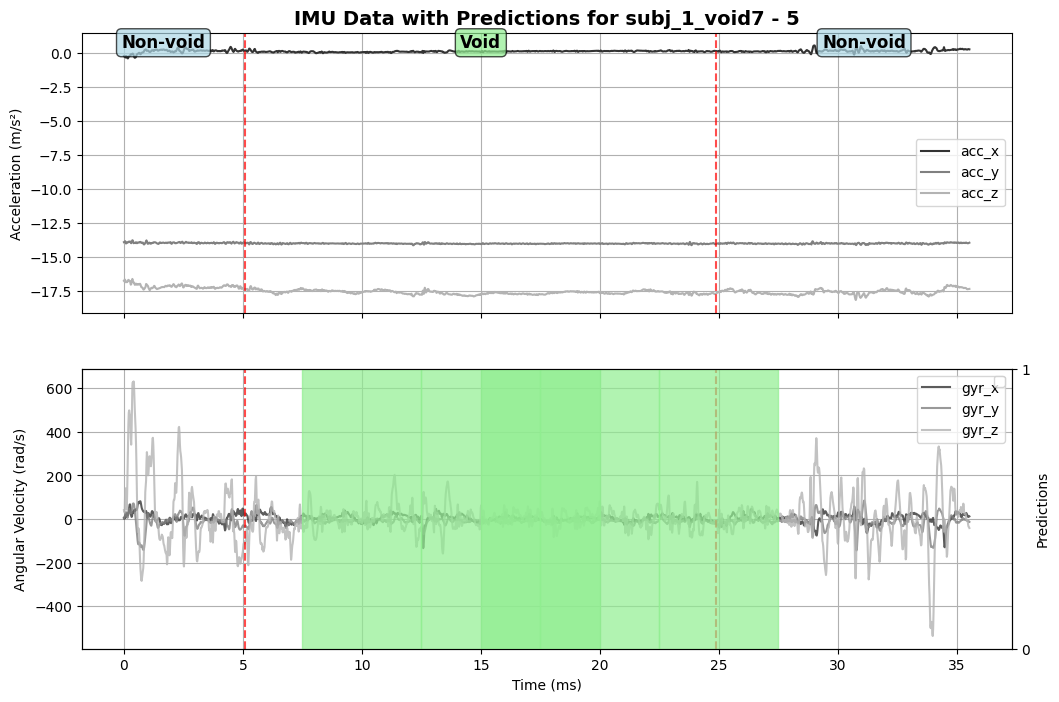

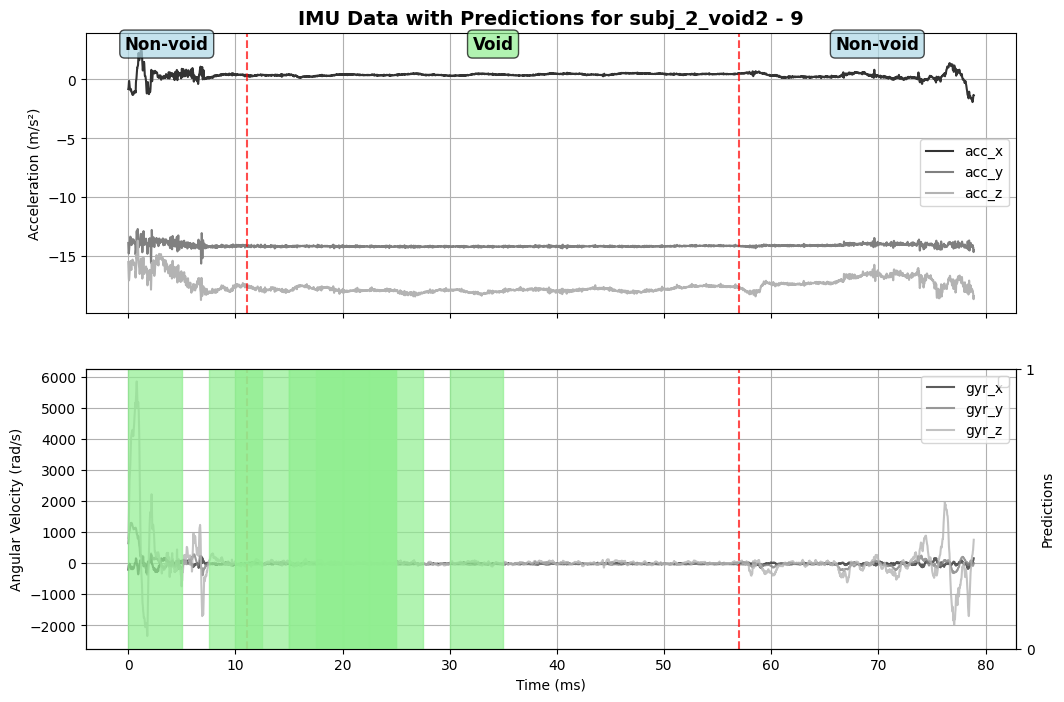

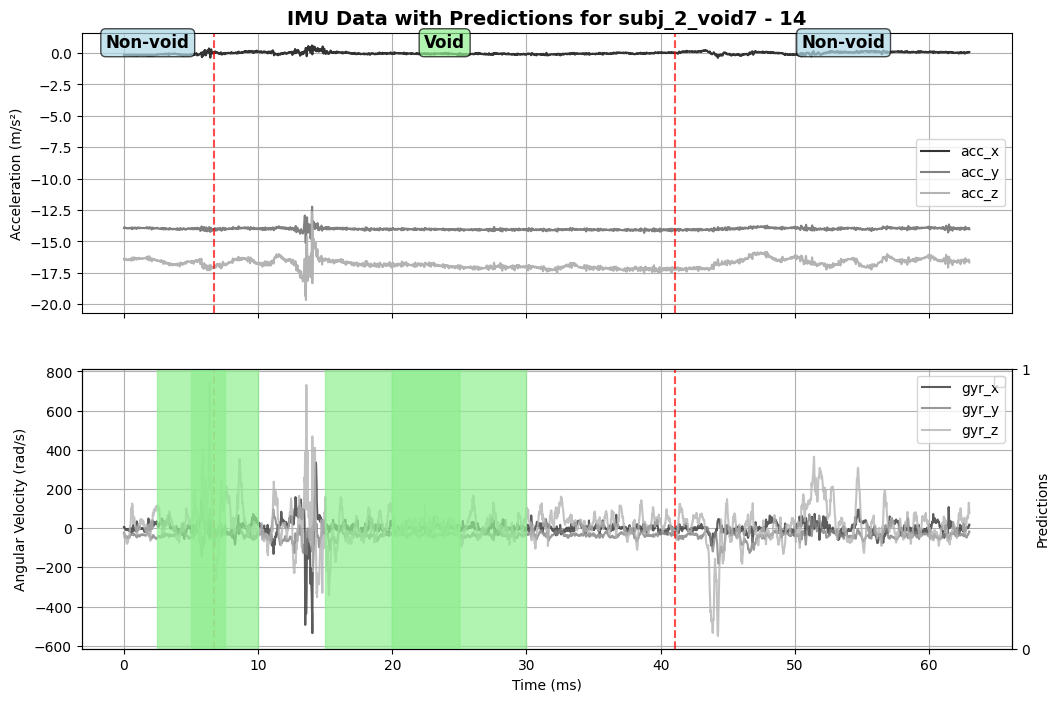

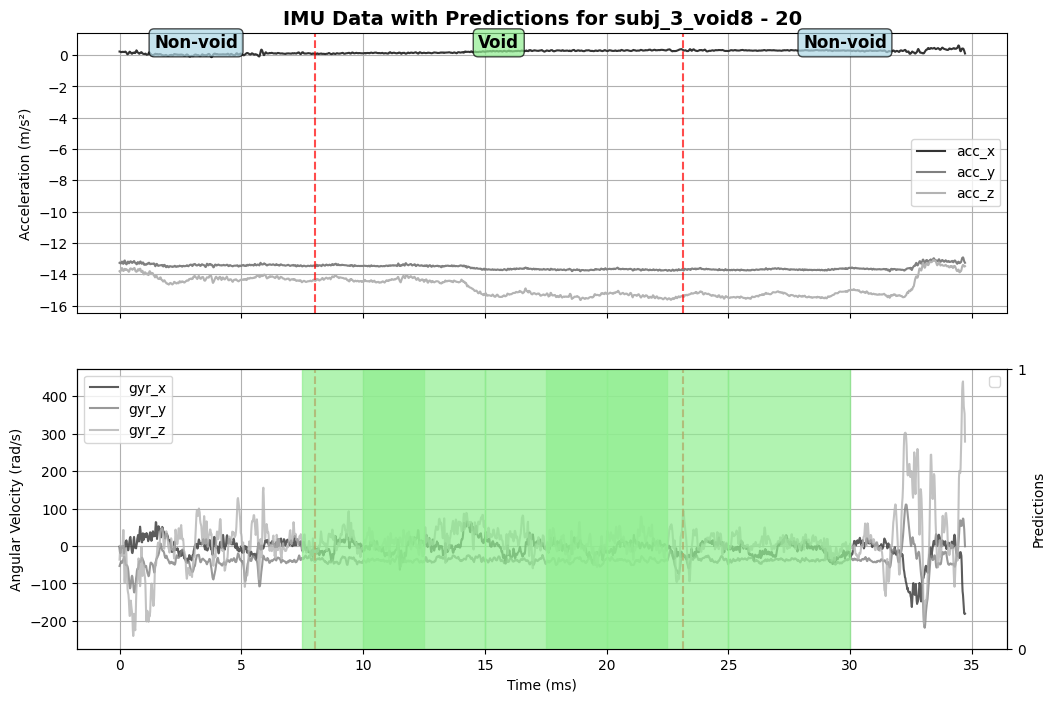

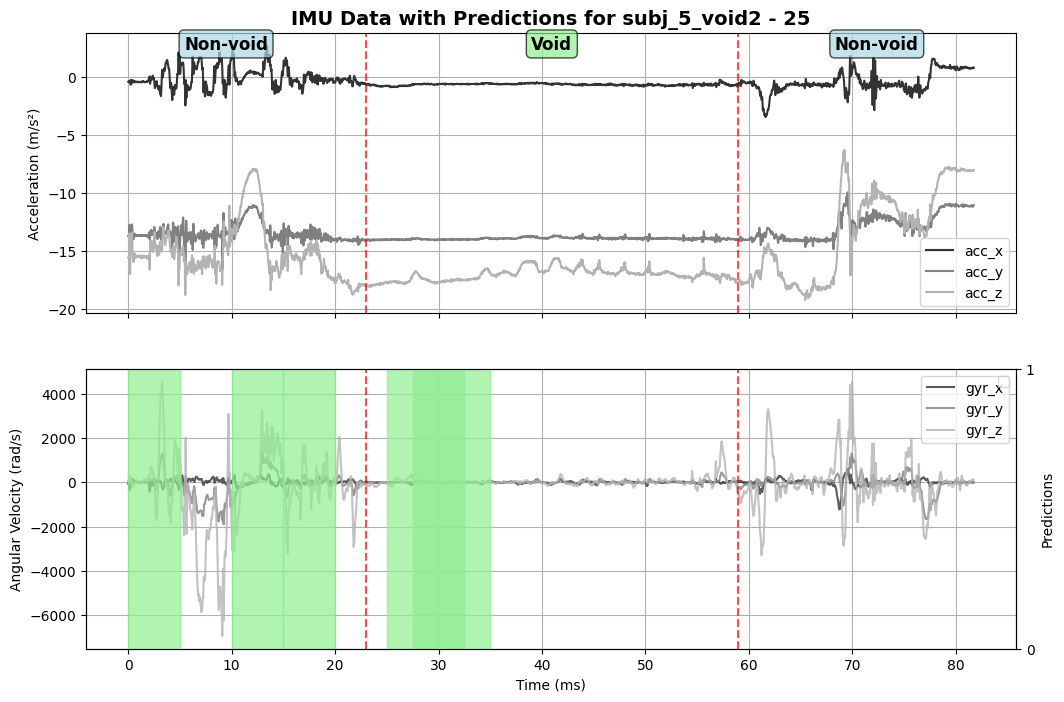

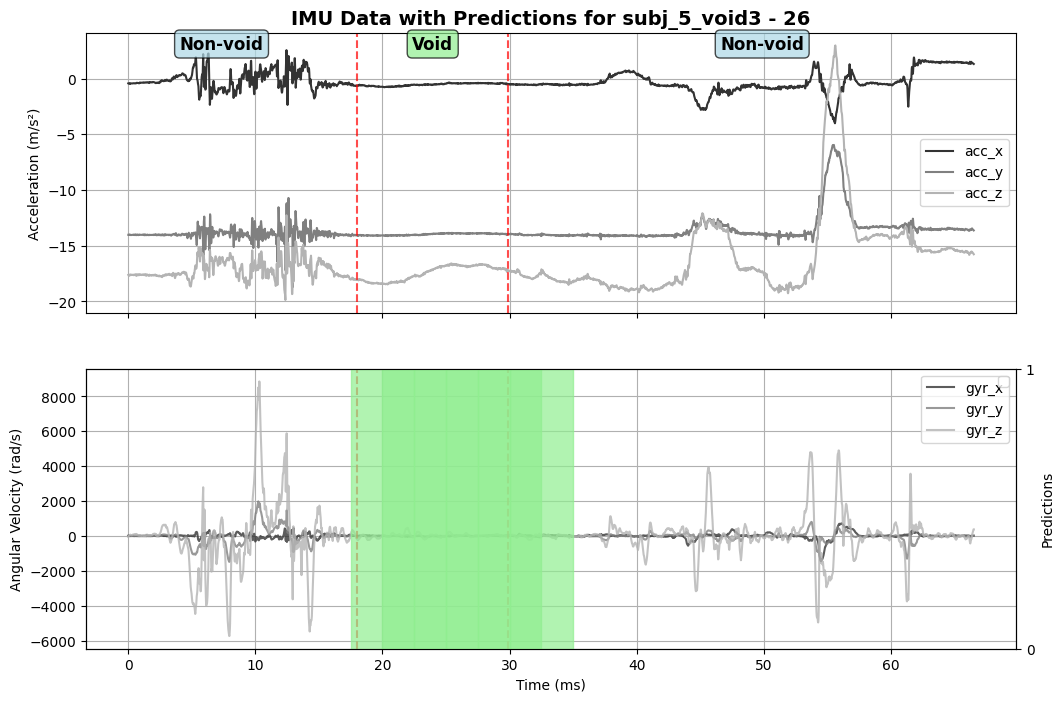

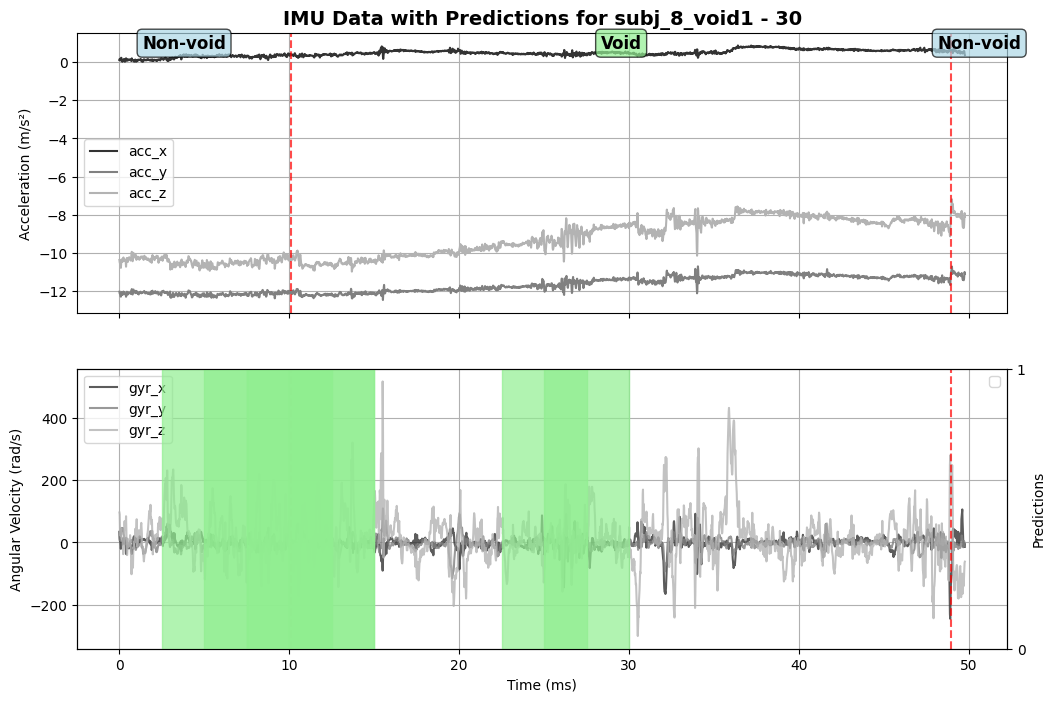

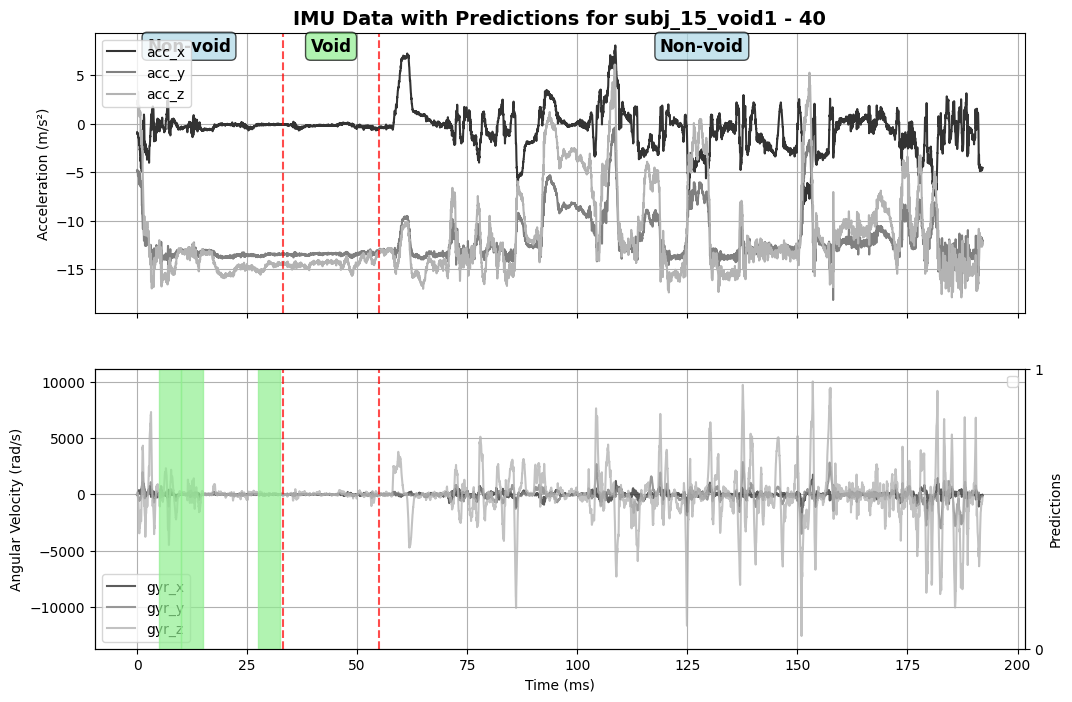

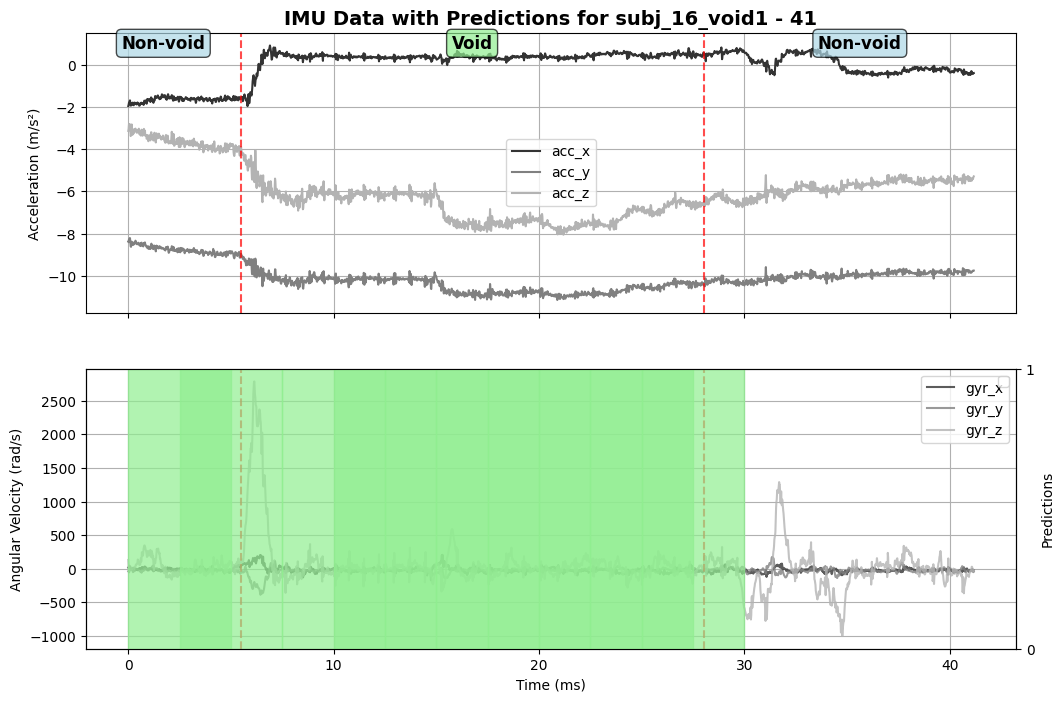

In [117]:

for i_void_instance, void_instance in enumerate(voids.keys()):
    imu_data = imu_dict[void_instance]
    urine_estimates = urine_estimates_dict[void_instance]
    ground_truth = ground_truth_dict[void_instance]
    exp_id = voids[void_instance]
        
    # Urination event is the first and last time of the ground truth data
    urination_event = [ground_truth['Time'].iloc[0], ground_truth['Time'].iloc[-1]] 

    # Create a figure with 2 subplots (shared x-axis)
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # --- Top subplot: Accelerometer ---
    ax_top.plot(imu_data['time'], imu_data['acc_x'], color='0.2', label='acc_x')
    ax_top.plot(imu_data['time'], imu_data['acc_y'], color='0.5', label='acc_y')
    ax_top.plot(imu_data['time'], imu_data['acc_z'], color='0.7', label='acc_z')
    ax_top.set_ylabel('Acceleration (m/s²)')
    # Add title
    ax_top.set_title(f'IMU Data with Predictions for {void_instance} - {exp_id}', fontsize=14, fontweight='bold')
    ax_top.legend(loc='best')
    ax_top.grid(True)
        
    # Add vertical lines for urination event
    ax_top.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_top.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)

    # Add phase labels at the top of the top subplot only
    x_min, x_max = ax_top.get_xlim()
    y_min, y_max = ax_top.get_ylim()

    # Pre-void label
    pre_void_center = (x_min + urination_event[0]) / 2
    ax_top.text(pre_void_center, y_max * 0.95, 'Non-void', ha='center', va='top', 
                fontsize=12, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
        
    # Void label
    void_center = (urination_event[0] + urination_event[1]) / 2
    ax_top.text(void_center, y_max * 0.95, 'Void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
        
    # Post-void label
    post_void_center = (urination_event[1] + x_max) / 2
    ax_top.text(post_void_center, y_max * 0.95, 'Non-void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
        
    # --- Bottom subplot: Gyroscope ---
    ax_bottom.plot(imu_data['time'], imu_data['gyr_x'], color='0.2', label='gyr_x', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_y'], color='0.5', label='gyr_y', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_z'], color='0.7', label='gyr_z', alpha=0.8)
    ax_bottom.set_ylabel('Angular Velocity (rad/s)')
    ax_bottom.set_xlabel('Time (ms)')
    ax_bottom.legend(loc='best')
    ax_bottom.grid(True)
        
    # Add vertical lines for urination event
    ax_bottom.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_bottom.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)


    # --- Overlay predictions on bottom subplot ---
    ax_pred = ax_bottom.twinx()
    predicted_labels = test_results[test_results['group'] == exp_id]['predicted'].tolist()
    actual_labels = test_results[test_results['group'] == exp_id]['actual'].tolist()
    features_df_ = test_features_[test_features_['experiment_id'] == exp_id]
    print(f"Experiment ID: {exp_id}; Instance: {void_instance}")
    print(predicted_labels)
    plot_predictions_with_timing(test_features_, predicted_labels, ax_pred)


    # Add legend that combines both axes# model.fit(X_train, y_train)

    lines1, labels1 = ax_bottom.get_legend_handles_labels()
    lines2, labels2 = ax_pred.get_legend_handles_labels()
    ax_bottom.legend(lines1 + lines2, labels1 + labels2, loc='best')
        
        
    # path_5s_0_5 = 'plots'
    # # Save plot   
    # if not os.path.exists(path_5s_0_5):
    #     os.mkdir(path_5s_0_5)
    #     filename = os.path.join(path_5s_0_5, f'{void_instance}_overlay.png')
    #     plt.savefig(filename)
    # else:
    #     filename = os.path.join(path_5s_0_5, f'{void_instance}_overlay.png')
    #     plt.savefig(filename)
    # plt.close()

# HMM

In [57]:
y_pred_prob

array([[0.77269304, 0.22730693],
       [0.7816135 , 0.21838646],
       [0.8328879 , 0.16711213],
       [0.7307039 , 0.2692961 ],
       [0.73908454, 0.26091546],
       [0.51692015, 0.48307985],
       [0.34047782, 0.6595222 ],
       [0.40561885, 0.59438115],
       [0.716527  , 0.283473  ],
       [0.63311195, 0.36688808],
       [0.7946029 , 0.20539713],
       [0.74757296, 0.25242704],
       [0.79004586, 0.20995417],
       [0.92586935, 0.07413067],
       [0.8504852 , 0.14951482],
       [0.83202565, 0.16797434],
       [0.489039  , 0.510961  ],
       [0.4159184 , 0.5840816 ],
       [0.44790602, 0.552094  ],
       [0.45271176, 0.54728824],
       [0.4270016 , 0.5729984 ],
       [0.1962443 , 0.8037557 ],
       [0.3740136 , 0.6259864 ],
       [0.557289  , 0.44271097],
       [0.47474706, 0.52525294],
       [0.35579628, 0.6442037 ],
       [0.26113945, 0.73886055],
       [0.47915447, 0.52084553],
       [0.6474837 , 0.35251626],
       [0.3475206 , 0.6524794 ],
       [0.

In [59]:
groups_test.values

array([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40

In [ ]:
y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=classes)
y_pred_prob_df['experiment_id'] = groups_test.values

In [62]:
void_probs_exp_ids = y_pred_prob_df.drop(columns=['non-void'])
void_probs_exp_ids

,void,experiment_id
0,0.227307,5
1,0.218386,5
2,0.167112,5
3,0.269296,5
4,0.260915,5
...,...,...
238,0.771966,41
239,0.463372,41
240,0.520841,41
241,0.525950,41


In [ ]:
import numpy as np
import pandas as pd
from hmmlearn import hmm

def implementation_2_best_seed(df, prob_col='void', id_col='experiment_id', n_states=3, seeds=range(200)):
    transmat = np.array([
        [0.7, 0.3, 0.0],    # pre-void -> mostly stay, can go to void
        [0.0, 0.90, 0.1],   # void -> mostly stay, can go to post-void
        [0.0, 0.0, 1.0]     # post-void -> terminal
    ])
    
    startprob = np.array([1.0, 0.0, 0.0])
    
    # Prepare combined observations once
    all_obs = []
    lengths = []
    for exp_id, group in df.groupby(id_col):  # Fixed: was id*col
        observations = (group[prob_col] >= 0.35).astype(int).to_numpy().reshape(-1, 1)
        all_obs.append(observations)
        lengths.append(len(observations))
    all_obs = np.vstack(all_obs)
    
    best_score = -np.inf
    best_model = None
    best_seed = None  # Initialize to avoid UnboundLocalError
    
    # Try multiple seeds and keep the best
    for seed in seeds:
        try:
            model = hmm.CategoricalHMM(
                n_components=n_states,
                init_params="e",  # only emissions will be learned
                n_iter=100,
                tol=1e-4,
                random_state=seed
            )
            model.startprob_ = startprob
            model.transmat_ = transmat
            model.fit(all_obs, lengths)
            score = model.score(all_obs, lengths)
            
            if score > best_score:
                best_score = score
                best_model = model
                best_seed = seed
                
        except Exception as e:
            print(f"Seed {seed} failed: {e}")
            continue
    
    if best_model is None:
        raise ValueError("All seeds failed to converge!")
    
    # Decode using the best model
    state_map = {0: 'pre-void', 1: 'void', 2: 'post-void'}
    all_results = []
    
    for exp_id, group in df.groupby(id_col):
        observations = (group[prob_col] >= 0.35).astype(int).to_numpy().reshape(-1, 1)
        _, hidden_states = best_model.decode(observations, algorithm="viterbi")  # Fixed: was *, hidden*states
        
        group_result = group.copy()
        group_result['predicted_state'] = [state_map[s] for s in hidden_states]
        all_results.append(group_result)
    
    return pd.concat(all_results), best_model.emissionprob_, best_score, best_seed

In [53]:
# # Method 2: If windows are consecutive with known step size
# def reconstruct_with_step(predictions, window_size, step_size, start_time=0):
#     """
#     Reconstruct when you know the step size between windows
#     """
#     timeline_positions = []
#     timeline_predictions = []
    
#     for i, pred in enumerate(predictions):
#         # Calculate the center time of this window
#         window_start = start_time + (i * step_size)
#         window_center = window_start + (window_size // 2)
        
#         timeline_positions.append(window_center)
#         timeline_predictions.append(pred)
    
#     return pd.DataFrame({
#         'time_position': timeline_positions,
#         'prediction': timeline_predictions
#     })

In [54]:
# import matplotlib.pyplot as plt

# # Reconstruct your timeline
# timeline_df = reconstruct_with_step(predicted_labels, window_size=5, step_size=0.5)

# # Plot like your diagram
# plt.figure(figsize=(12, 4))

# # Plot the predictions as a timeline
# plt.step(timeline_df['time_position'], timeline_df['prediction'], 
#         where='mid', linewidth=2, label='Predicted Labels')


# plt.xlabel('Time')
# plt.ylabel('Predicted Label')
# plt.title('Timeline Reconstruction from Sliding Window Predictions')
# plt.legend()
# plt.show()

In [55]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print()